In [ ]:
# Mount the Google drive with the notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download Dataset
dataset link: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection

In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
# create kaggle folder
!mkdir ~/.kaggle

# copy the kaggle.json to the folder created
!cp /content/drive/MyDrive/Colab_Notebooks/Kaggle_API_Token/kaggle.json ~/.kaggle/

# permission for the jason to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Loading the dataset using Kaggle API Command
!kaggle datasets download -d andrewmvd/road-sign-detection

 98% 213M/218M [00:01<00:00, 163MB/s]
100% 218M/218M [00:01<00:00, 149MB/s]


In [ ]:
# Unzipping the dataset
!unzip /content/road-sign-detection.zip

# Setup Necessary Paths

Tensorflow Model Zoo: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [ ]:
import os

In [ ]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [ ]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [ ]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
# create the directories
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [ ]:
# Divide the dataset into train and test sets

import os
import shutil
import random
random.seed(42)

TRAIN_SIZE = 0.9

IMAGES_SOURCE_DIR = '/content/images'
ANNOTATIONS_SOUCE_DIR = '/content/annotations'

file_names = [fil[:-4] for fil in os.listdir(IMAGES_SOURCE_DIR) if fil[-4:] == '.png']
file_names = sorted(file_names)

file_names_train = random.sample(file_names, int(len(file_names)*TRAIN_SIZE))
file_names_test = [fil for fil in file_names if fil not in file_names_train]

os.mkdir(os.path.join(paths['IMAGE_PATH'], 'train'))
os.mkdir(os.path.join(paths['IMAGE_PATH'], 'test'))

for file_name in file_names_train:
    image_source = os.path.join('/content/images', file_name+'.png')
    annotation_source = os.path.join('/content/annotations', file_name+'.xml')
    image_destination = os.path.join(paths['IMAGE_PATH'], 'train', file_name+'.png')
    annotation_destination = os.path.join(paths['IMAGE_PATH'], 'train', file_name+'.xml')
    shutil.copyfile(image_source, image_destination)
    shutil.copyfile(annotation_source, annotation_destination)

for file_name in file_names_test:
    image_source = os.path.join('/content/images', file_name+'.png')
    annotation_source = os.path.join('/content/annotations', file_name+'.xml')
    image_destination = os.path.join(paths['IMAGE_PATH'], 'test', file_name+'.png')
    annotation_destination = os.path.join(paths['IMAGE_PATH'], 'test', file_name+'.xml')
    shutil.copyfile(image_source, image_destination)
    shutil.copyfile(annotation_source, annotation_destination)

In [ ]:
print('No. of images: ', len(file_names))
print('No. of train images: ', int(len(os.listdir(os.path.join(paths['IMAGE_PATH'], 'train')))/2))
print('No. of test images: ', int(len(os.listdir(os.path.join(paths['IMAGE_PATH'], 'test')))/2))

No. of images:  877
No. of train images:  789
No. of test images:  88


In [ ]:
# get the all the class names
!grep -ERoh '<name>(.*)</name>' {os.path.join(paths['IMAGE_PATH'], 'train')} | sort | uniq | sed 's/<name>//g' | sed 's/<\/name>//g' > ./labels.txt

# Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# Download the tensorflow models git repo
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}
    !cd {paths['APIMODEL_PATH']} && git checkout 0aadb8d3e24181845a678f9856eae7e8deecdb83 # Commit of May 31, 2022

Cloning into 'Tensorflow/models'...
remote: Enumerating objects: 74478, done.
remote: Counting objects: 100% (498/498), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 74478 (delta 266), reused 441 (delta 224), pack-reused 73980
Receiving objects: 100% (74478/74478), 580.42 MiB | 24.31 MiB/s, done.
Resolving deltas: 100% (52755/52755), done.
Note: checking out '0aadb8d3e24181845a678f9856eae7e8deecdb83'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 0aadb8d3e Add per-class precision and recall for image classification task.


In [ ]:
# We'll use our custom setup.py file for TFOD installation

import os
import shutil

os.remove('/content/Tensorflow/models/research/object_detection/packages/tf2/setup.py')
shutil.copyfile(src = '/content/drive/MyDrive/Colab_Notebooks/Object_Detection/TFOD/TFOD_MaskDetection/setup.py',
                dst = '/content/Tensorflow/models/research/object_detection/packages/tf2/setup.py')

'/content/Tensorflow/models/research/object_detection/packages/tf2/setup.py'

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/Tensorflow/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     / 668.3 MB 411 kB/s
     |████████████████████████████████| 10.3 MB 13.0 MB/s 
     |█████

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-06-13 14:38:19.197241: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0613 14:38:19.628200 139891677276032 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 2.72s
I0613 14:38:20.354710 139891677276032 test_util.py:2374] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 2.72s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 1.15s
I0613 14:38:21.508203 139891677276032 test

In [ ]:
import object_detection

In [ ]:
# Download the pretrained model
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2022-06-13 14:38:56--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.98.128, 2607:f8b0:400e:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.98.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.1s    

2022-06-13 14:38:56 (195 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8

# Create Label Map

In [ ]:
# 4 Categories
labels = [{'name':'crosswalk', 'id':1},
          {'name':'speedlimit', 'id':2},
          {'name':'stop', 'id':3},
          {'name':'trafficlight', 'id':4}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# Create TF records

In [ ]:
# Download the generate_tfrecord.py
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/Suvam-Bit/GenerateTFRecord {paths['SCRIPTS_PATH']}

Cloning into 'Tensorflow/scripts'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [ ]:
# We'll use our custom generate_tfrecord.py to create TFRecord files

import os
import shutil

os.remove(os.path.join(paths['SCRIPTS_PATH'], 'generate_tfrecord.py'))
shutil.copyfile(src = '/content/drive/MyDrive/Colab_Notebooks/Object_Detection/TFOD/TFOD_RoadSign/generate_tfrecord.py',
                dst = os.path.join(paths['SCRIPTS_PATH'], 'generate_tfrecord.py'))

'Tensorflow/scripts/generate_tfrecord.py'

In [ ]:
# Create TFRecord files for train and test set
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# Copy Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# Update Config For Transfer Learning

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
config

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.9969999790191

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# Train the model

In [ ]:
!pip uninstall opencv-python-headless -y
!pip install opencv-python-headless==4.5.2.52

Found existing installation: opencv-python-headless 4.6.0.66
Uninstalling opencv-python-headless-4.6.0.66:
  Successfully uninstalled opencv-python-headless-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.2 MB 192 kB/s 


In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=20000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=20000


In [ ]:
 !{command}

2022-06-13 14:40:21.004975: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0613 14:40:21.010470 140607992412032 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 20000
I0613 14:40:21.014068 140607992412032 config_util.py:552] Maybe overwriting train_steps: 20000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0613 14:40:21.014223 140607992412032 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0613 14:40:21.158062 140607992412032 deprecation.py:343] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experime

# Evaluate the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --checkpoint_dir=Tensorflow/workspace/models/my_ssd_mobnet


In [ ]:
!{command}

W0613 15:15:09.989818 140353065920384 model_lib_v2.py:1090] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0613 15:15:09.990040 140353065920384 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0613 15:15:09.990127 140353065920384 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0613 15:15:09.990210 140353065920384 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0613 15:15:09.990325 140353065920384 model_lib_v2.py:1110] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2022-06-13 15:15:10.742476: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original confi

# Load Train Model From Checkpoint

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-21')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Detect from an Image

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

#### Detection Using visualization_utils

In [ ]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'road581.png')

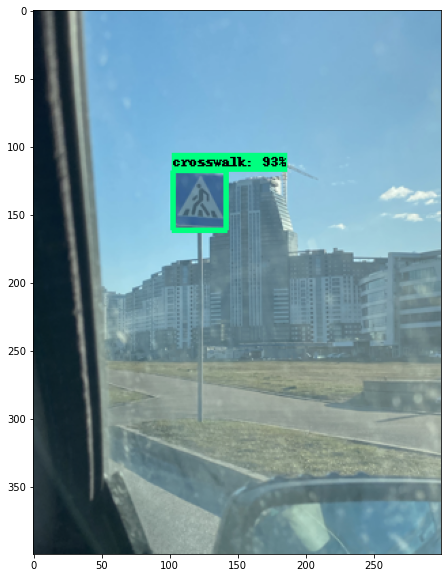

In [ ]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5,
            agnostic_mode=False)

plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

#### Detection Using Custom Detection Function

In [ ]:
colors = {'crosswalk': (255,0,0),
          'speedlimit': (0,234,255),
          'stop': (0,0,255),
          'trafficlight': (0,255,0)}

In [ ]:
def draw_label(image, label, x, y, box_color, font_color, font_face, font_scale):
    img = image.copy()

    text_size = cv2.getTextSize(label, fontFace=font_face, fontScale=font_scale, thickness=1)
    dim, baseline = text_size[0], text_size[1]
    
    # cv2.rectangle(img, (x,y), (x + dim[0], y + dim[1] + baseline), box_color, cv2.FILLED);
    # cv2.putText(img, label, (x, y + dim[1] + 2), fontFace=font_face, fontScale=font_scale, color=font_color, thickness=1)

    cv2.rectangle(img, (x, y - dim[1] - baseline), (x + dim[0], y), box_color, cv2.FILLED);
    cv2.putText(img, label, (x, y - dim[1] + 5), fontFace=font_face, fontScale=font_scale, color=font_color, thickness=1)

    return img

def detect_image(image, detection_threshold, category_index, colors):
    image_np = np.array(image)
    height = image_np.shape[0]
    width = image_np.shape[1]

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}

    bboxs = []
    scores = []
    classes = []
    
    for i in range(detections['detection_boxes'].shape[0]):
        if detections['detection_scores'][i] >= detection_threshold:
            bboxs.append(detections['detection_boxes'][i])
            scores.append(detections['detection_scores'][i])
            classes.append(detections['detection_classes'][i])

    for i in range(len(bboxs)):
        bbox = bboxs[i]
        ymin, xmin, ymax, xmax = int(bbox[0]*height), int(bbox[1]*width), int(bbox[2]*height), int(bbox[3]*width)
        score = int(scores[i]*100)
        clas = classes[i]
        label = f"{category_index[clas+1]['name']} : {score}%"
        color = colors[category_index[clas+1]['name']]

        cv2.rectangle(image_np, (xmin, ymin), (xmax, ymax), color = color, thickness = 2)
        image_np = draw_label(image_np, label, xmin, ymin, color, (0,0,0), cv2.FONT_HERSHEY_SIMPLEX, 0.4)

    return image_np


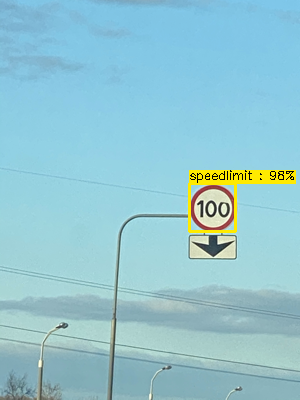

In [ ]:
from google.colab.patches import cv2_imshow

IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'road800.png')
image = cv2.imread(IMAGE_PATH)

detected_image = detect_image(image,
                              detection_threshold = 0.5,
                              category_index = category_index,
                              colors = colors)

cv2_imshow(detected_image)

# Zip and Export The Trained Model 

In [ ]:
!tar -czf my_ssd_mobilenet_v2_fpnlite_320x320_epoch_20000.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
import shutil

my_model_file_path = '/content/my_ssd_mobilenet_v2_fpnlite_320x320_epoch_20000.tar.gz'
my_model_file_path_drive = '/content/drive/MyDrive/Colab_Notebooks/Object_Detection/TFOD/TFOD_RoadSign/saved_models/my_ssd_mobilenet_v2_fpnlite_320x320_epoch_20000.tar.gz'

shutil.copyfile(my_model_file_path, my_model_file_path_drive)

'/content/drive/MyDrive/Colab_Notebooks/Object_Detection/TFOD/TFOD_RoadSign/saved_models/my_ssd_mobilenet_v2_fpnlite_320x320_epoch_20000.tar.gz'